In [1]:
import numpy as np  
from matplotlib import pyplot as plt 
from PIL import Image   
from pytorch_lightning import Trainer   
import torch

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model  
from anomalib.data.utils import read_image
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.models.components import feature_extractors

/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OpenVINO is not installed. Please install OpenVINO to use OpenVINOInferencer.
OpenVINO is not installed. Please install OpenVINO to use OpenVINOInferencer.


To use wandb logger install it using `pip install wandb`


In [2]:
MODEL = "patchcore"
CONFIG_PATH = f"/home/students/tyang/anomalib/src/anomalib/models/{MODEL}/config.yaml"
with open(file=CONFIG_PATH, mode="r",encoding="utf-8") as f:
    print(f.read())
    
config = get_configurable_parameters(config_path=CONFIG_PATH)


/home/students/tyang/anomalib/src/anomalib/config/config.py:243: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/home/students/tyang/anomalib/src/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


dataset:
  name: airogs
  format: airogs
  path: /home/students/tyang/airogs 
  task: classification # options: [classification, segmentation]
  category: 0
  number_of_samples: 17999
  pre_selection: False
  train_batch_size: 1000
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: 224 # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.2 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stri

In [3]:

data_module = get_datamodule(config=config)
data_module.prepare_data() # check if the dataset is avaliable
data_module.setup()

i, val_data = next(enumerate(data_module.val_dataloader()))
#print(val_data.keys())

i, train_data = next(enumerate(data_module.train_dataloader()))
#print(train_data.keys())

i, test_data = next(enumerate(data_module.test_dataloader()))
#print(test_data.keys())

#print(train_data["image_path"][10])


In [112]:
print(train_data["image"].shape)

torch.Size([1000, 3, 224, 224])


showing training data


/home/students/tyang/anomalib/src/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


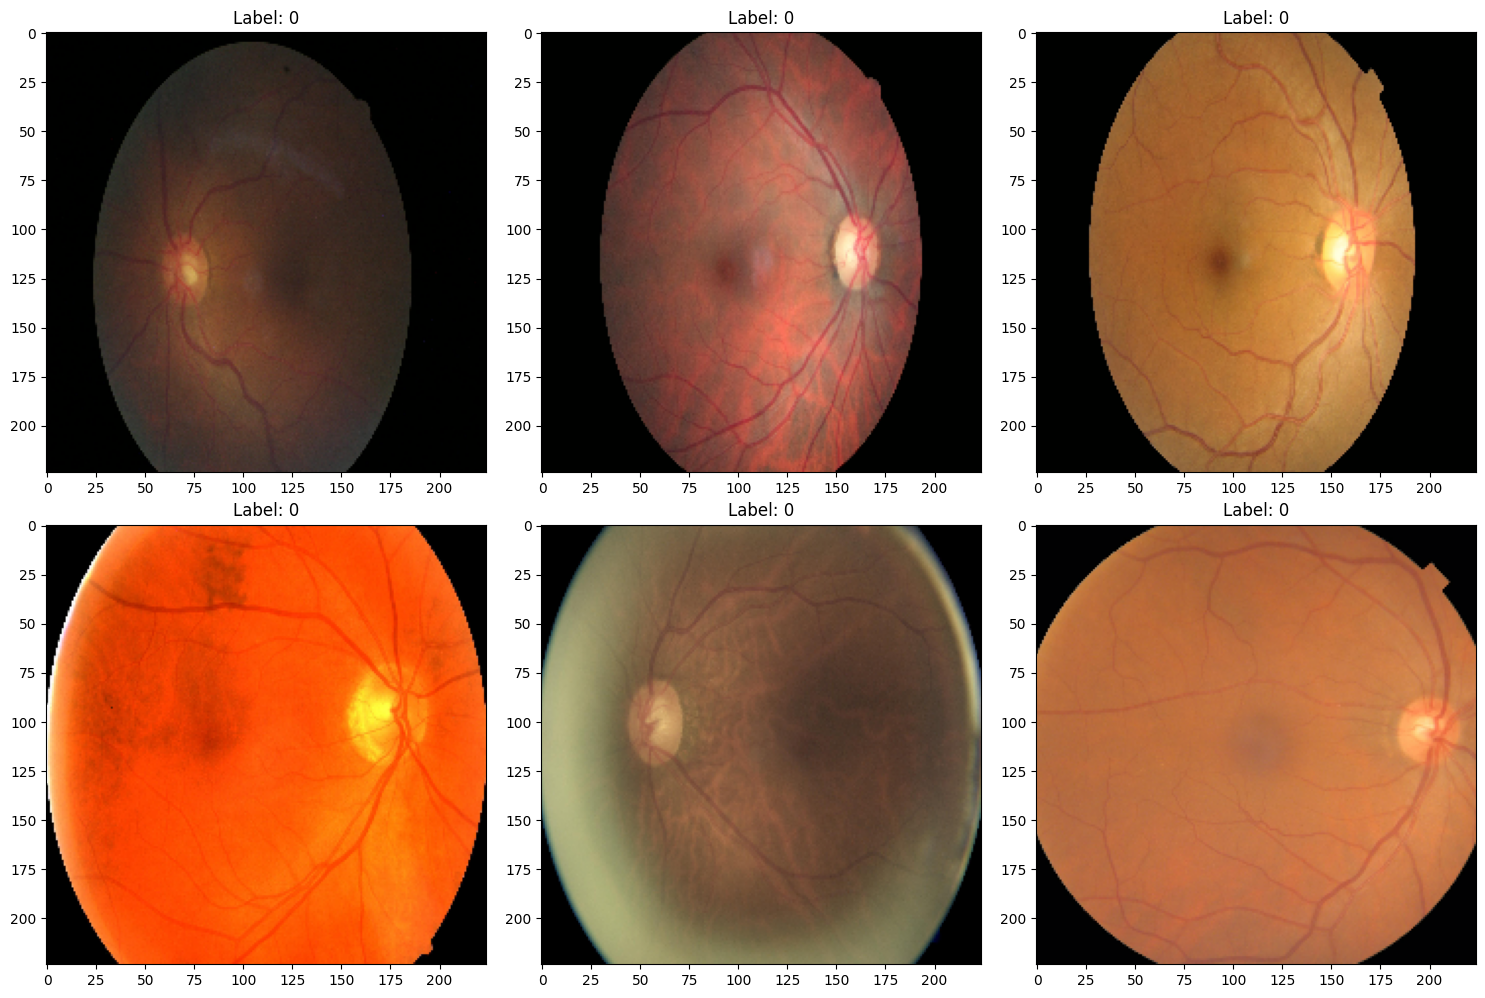

followed by test data


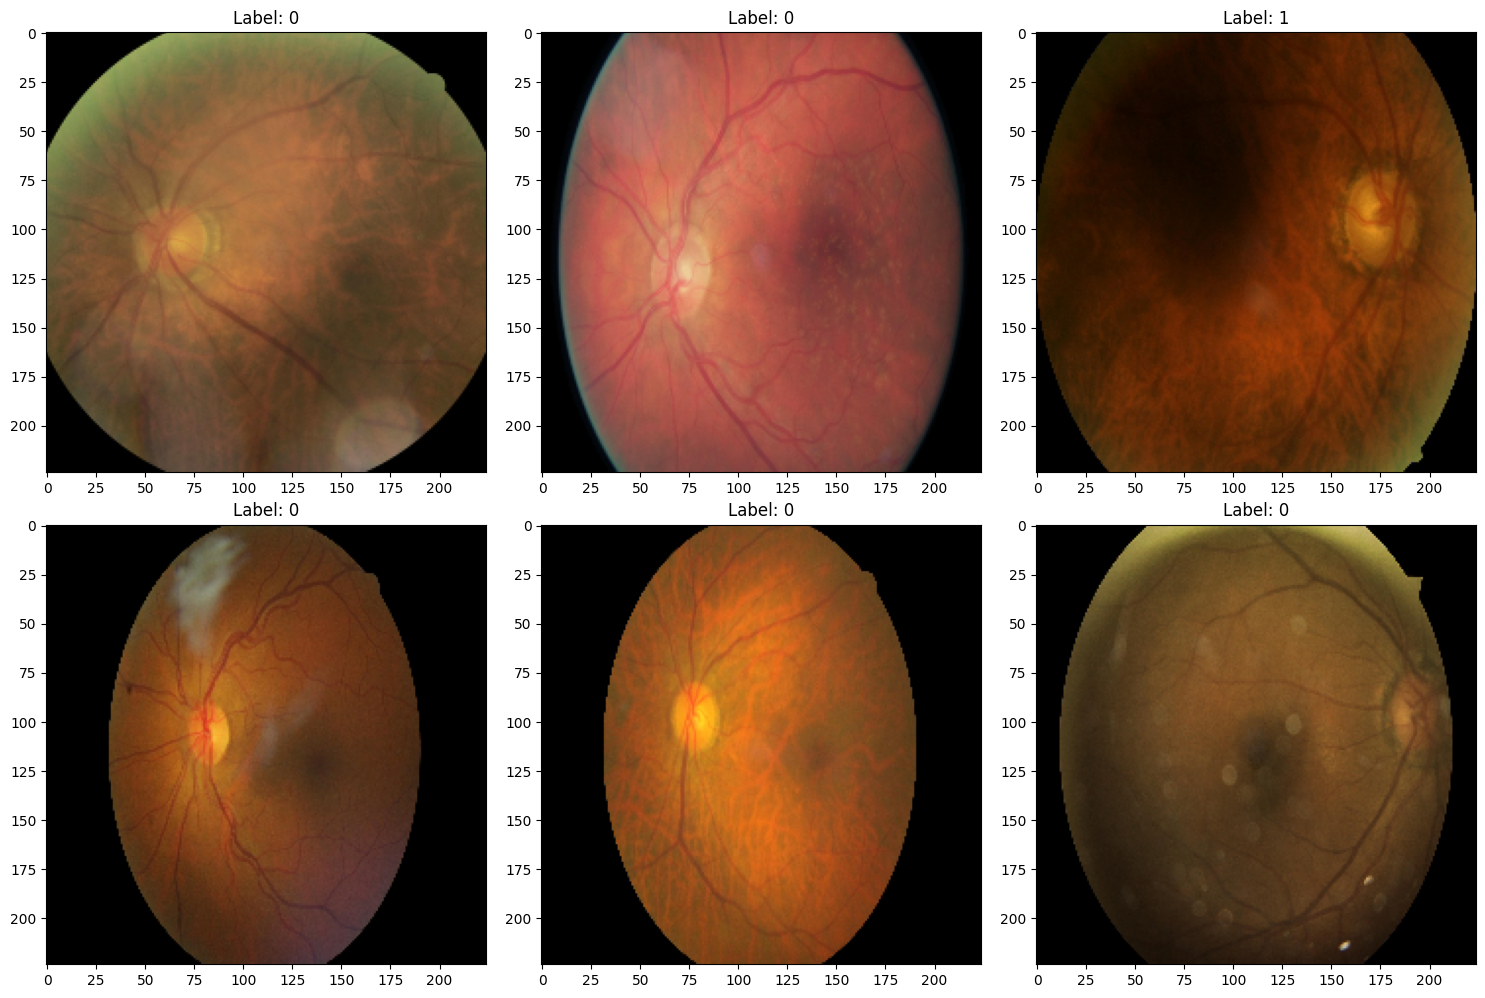

In [113]:
import random
from typing import Any
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from anomalib.pre_processing.transforms import Denormalize
def show_image(sample:dict[str, Any], idx:int):
    img = ToPILImage()(Denormalize()(sample["image"][idx]))
    plt.title(f"Label: {sample['label'][idx]}")
    plt.imshow(img)
    plt.show()



def display_images(sample:dict[str, Any], num_of_images:int):
    """ Display a random sample of images from the dataset
    
    Args: 
        sample (dict[str, Any]): a sample from the dataset , e.g data from dataloader
        num_of_images (int): number of images to display
    """
    num_rows = (num_of_images + 2 ) // 3
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
    for i in range(num_of_images):
        random_idx = random.randint(0, len(sample["label"])-1)
        img = ToPILImage()(Denormalize()(sample["image"][random_idx]))
        axs[i//3, i%3].imshow(img)
        axs[i//3, i%3].set_title(f"Label: {sample['label'][i]}")
    
    plt.tight_layout()
    plt.show()


print("showing training data")    
display_images(sample=train_data, num_of_images=6)
print("followed by test data")
display_images(sample=test_data, num_of_images=6)



/tmp/ipykernel_145364/835122559.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(data["label"])


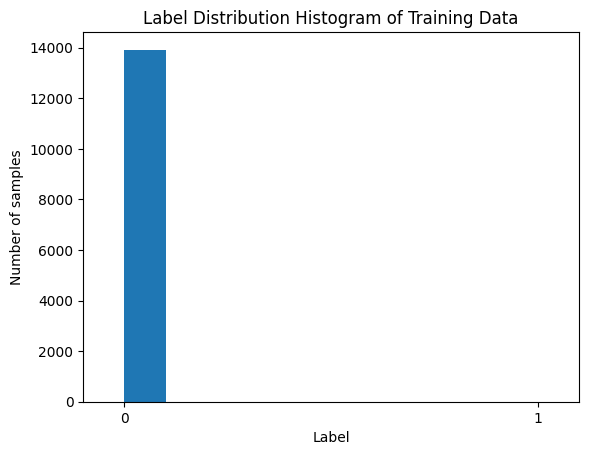

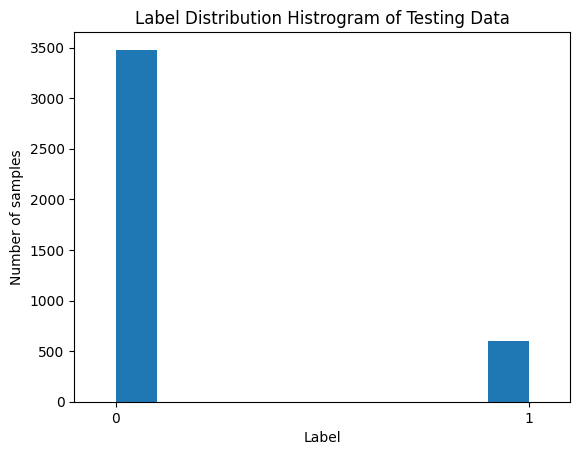

In [114]:
def show_dataloader_label_distribution(dataloader):
    """Args: dataloader: pytorch lightning dataloader
       Plots the label distribution of the dataloader
    """
    labels= []
    for i, data in enumerate(dataloader):
        label = torch.tensor(data["label"])
        labels.append(label)
    labels = torch.cat(labels) 
    label_list = [0 , 1]
    plt.hist(labels)
    plt.xticks(label_list)
    plt.xlabel("Label")
    plt.ylabel("Number of samples")
    plt.xlim(-0.1,1.1)
    plt.show()   

plt.title("Label Distribution Histogram of Training Data")
show_dataloader_label_distribution(data_module.train_dataloader())

plt.title("Label Distribution Histrogram of Testing Data")
show_dataloader_label_distribution(data_module.test_dataloader())

In [4]:
import torchvision
from anomalib.models.components.feature_extractors import TorchFXFeatureExtractor
from torchvision.models.densenet import DenseNet201_Weights

import torchvision.models as models
print(torchvision.models.feature_extraction.get_graph_node_names(models.densenet201(pretrained=True)))

feature_extractor = TorchFXFeatureExtractor(
                    backbone="densenet201",
                    return_nodes=["features.denseblock1.denselayer6.conv2", "features.denseblock2.denselayer12.conv2"],
                    weights=DenseNet201_Weights.IMAGENET1K_V1,
                )

features = feature_extractor(train_data["image"])
#print(len(features))
#print(features.keys())



/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torch/overrides.py

(['x', 'features.conv0', 'features.norm0', 'features.relu0', 'features.pool0', 'features.denseblock1.denselayer1.cat', 'features.denseblock1.denselayer1.norm1', 'features.denseblock1.denselayer1.relu1', 'features.denseblock1.denselayer1.conv1', 'features.denseblock1.denselayer1.norm2', 'features.denseblock1.denselayer1.relu2', 'features.denseblock1.denselayer1.conv2', 'features.denseblock1.denselayer2.cat', 'features.denseblock1.denselayer2.norm1', 'features.denseblock1.denselayer2.relu1', 'features.denseblock1.denselayer2.conv1', 'features.denseblock1.denselayer2.norm2', 'features.denseblock1.denselayer2.relu2', 'features.denseblock1.denselayer2.conv2', 'features.denseblock1.denselayer3.cat', 'features.denseblock1.denselayer3.norm1', 'features.denseblock1.denselayer3.relu1', 'features.denseblock1.denselayer3.conv1', 'features.denseblock1.denselayer3.norm2', 'features.denseblock1.denselayer3.relu2', 'features.denseblock1.denselayer3.conv2', 'features.denseblock1.denselayer4.cat', 'feat

In [ ]:
print(features["features.denseblock1.denselayer6.conv2"].shape)
print(features["features.denseblock2.denselayer12.conv2"].shape)
print(train_data["image"].shape)

torch.Size([1000, 32, 56, 56])
torch.Size([1000, 32, 28, 28])
torch.Size([1000, 3, 224, 224])


In [117]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

feature_tensor = features["adaptive_avg_pool2d"].reshape(features["adaptive_avg_pool2d"].shape[0], -1)
distortions = []
K_range = range(1, 11)  # Try different values of k

for k in K_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feature_tensor)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()

KeyError: 'adaptive_avg_pool2d'

/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packa

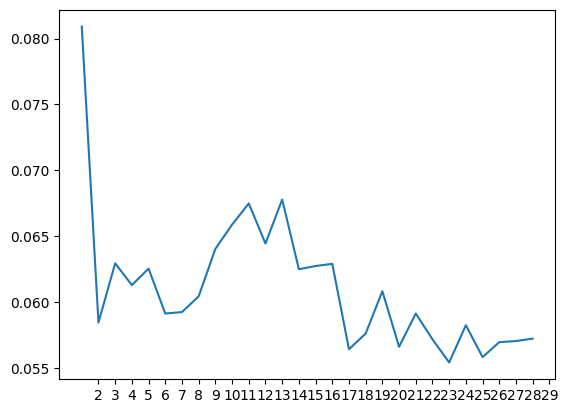

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import numpy as np



silhouette_avg = []
for i in range(2,30):
    kmeans_fit = KMeans(n_clusters = i).fit(feature_tensor)
    silhouette_avg.append(silhouette_score(feature_tensor, kmeans_fit.labels_))


x_ticks = np.linspace(2, 30 , 29)
plt.xticks(x_ticks)
plt.plot(range(1,29), silhouette_avg)


In [5]:
from anomalib.models.components.cluster.kmeans import KMeans
import torch

feature_tensor = features["features.denseblock1.denselayer6.conv2"]
feature_tensor = feature_tensor.permute(1,0,2,3)
feature_tensor = feature_tensor.flatten(start_dim=1)
feature_tensor = feature_tensor.permute(1,0)
print(feature_tensor.shape)
kmeans = KMeans(n_clusters=12)
kmeans.fit(feature_tensor)
#import ipdb; ipdb.set_trace()
clusters_centers = kmeans.cluster_centers_




torch.Size([3136000, 32])


In [6]:
print(clusters_centers.shape)
print(len(clusters_centers))
#print(clusters_centers)

torch.Size([12, 32])
12


In [ ]:
import torch.nn as nn

def bag_of_words_statistics(Ptst, Cref, S):
    """Params:

    Ptst: Feature tensor of a set of images, tensor of shape (N, C, H, W)
    Cref: Cluster centers, tensor of shape (K, C)
    S: number of subregions per image dimension, integer

    Returns:
    bow_stats: list of Bag-of-words statistics, length N, each element is a tensor of shape (S, S, K)
    """
    Ptst = torch.vsplit(Ptst, Ptst.shape[0])
    bow_stats = []
    for Itst in Ptst:
    # Ptst_flattened = Ptst.view(-1)
        #print(Itst.shape)
        Itst = Itst.squeeze(0)
        #Itst = Itst.flatten()
        #Itst = Itst.permute(1,0)
        
        subtensors = torch.chunk(Itst, S, dim=1)
        subtensor = [torch.chunk(st, S, dim=2) for st in subtensors]
        #print(subtensor[0][0].shape)
        
        image_bow_stats = torch.zeros(S, S, len(Cref), dtype=torch.float32)
        for i in range(S):
            for j in range(S):
                new_subtensor = subtensor[i][j]
                #print(new_subtensor.shape)
                new_subtensor = new_subtensor.flatten(start_dim=1)
                
                new_subtensor = new_subtensor.permute(1,0)
                #print(new_subtensor.shape)
                idx = kmeans.predict(new_subtensor)
                #print(idx.shape)
                #print(idx)
                idx = idx.float()
                hist = torch.histc(idx, bins = len(Cref), min = torch.min(idx), max = torch.max(idx))
                normalized_hist = hist / torch.sum(hist)
                #print(normalized_hist)
                image_bow_stats[i][j] = normalized_hist
        #print(image_bow_stats.shape)


        bow_stats.append(image_bow_stats)
            
        
    return bow_stats

        
 
feature = features["features.denseblock1.denselayer6.conv2"]
bow_stats = bag_of_words_statistics(feature, clusters_centers, 4)
#print(bow_stats)

In [ ]:
print(len(bow_stats))
print(bow_stats[0].shape)
print(bow_stats)

1000
torch.Size([4, 4, 12])
[tensor([[[0.0867, 0.0000, 0.0255, 0.1224, 0.2500, 0.0000, 0.0357, 0.0459,
          0.0204, 0.0510, 0.1990, 0.1633],
         [0.0612, 0.0969, 0.0306, 0.1276, 0.0612, 0.0357, 0.1071, 0.1020,
          0.1684, 0.0663, 0.0000, 0.1429],
         [0.0867, 0.2092, 0.0612, 0.0255, 0.1939, 0.0204, 0.0408, 0.0561,
          0.0459, 0.1480, 0.0561, 0.0561],
         [0.1071, 0.0918, 0.1173, 0.0051, 0.0816, 0.0102, 0.0102, 0.0867,
          0.0000, 0.1071, 0.3622, 0.0204]],

        [[0.0255, 0.1633, 0.0255, 0.0255, 0.2398, 0.0918, 0.0051, 0.0255,
          0.0306, 0.1939, 0.1122, 0.0612],
         [0.0102, 0.2347, 0.0102, 0.0153, 0.1684, 0.0816, 0.0051, 0.0612,
          0.0918, 0.1939, 0.0051, 0.1224],
         [0.1122, 0.1429, 0.1224, 0.0918, 0.0765, 0.0306, 0.0714, 0.1531,
          0.0561, 0.0561, 0.0102, 0.0765],
         [0.0663, 0.0765, 0.0918, 0.0102, 0.0612, 0.1122, 0.0102, 0.1071,
          0.0969, 0.0561, 0.1327, 0.1786]],

        [[0.1276, 0.1173, 0.076

In [ ]:
def bag_of_words_statistics(Ptst, Cref, S):
    """Params:

    Ptst: Feature tensor of a set of images, tensor of shape (N, C, H, W)
    Cref: Cluster centers, tensor of shape (K, C)
    S: number of subregions per image dimension, integer

    Returns:
    bow_stats: list of Bag-of-words statistics, length N, each element is a tensor of shape (S * S, K)
    """
    Ptst = torch.vsplit(Ptst, Ptst.shape[0])
    bow_stats = []
    for Itst in Ptst:
        Itst = Itst.squeeze(0)
        
        subtensors = torch.chunk(Itst, S, dim=1)
        subtensor = [torch.chunk(st, S, dim=2) for st in subtensors]
        
        
        image_bow_stats = torch.zeros(S * S, len(Cref), dtype=torch.float32)
        for i in range(S):
            for j in range(S):
                new_subtensor = subtensor[i][j]
                
                new_subtensor = new_subtensor.flatten(start_dim=1)
                
                new_subtensor = new_subtensor.permute(1,0)
                
                idx = kmeans.predict(new_subtensor)
                
                idx = idx.float()
                hist = torch.histc(idx, bins = len(Cref), min = torch.min(idx), max = torch.max(idx))
                normalized_hist = hist / torch.sum(hist)
                
                image_bow_stats[i * S + j] = normalized_hist
        

        bow_stats.append(image_bow_stats)
            
        
    return bow_stats

        
 
feature = features["features.denseblock1.denselayer6.conv2"]
bow_stats_1 = bag_of_words_statistics(feature, clusters_centers, 4)

In [ ]:
print(len(bow_stats_1))
print(bow_stats_1[0].shape)
print(bow_stats_1)

1000
torch.Size([16, 12])
[tensor([[0.0867, 0.0000, 0.0255, 0.1224, 0.2500, 0.0000, 0.0357, 0.0459, 0.0204,
         0.0510, 0.1990, 0.1633],
        [0.0612, 0.0969, 0.0306, 0.1276, 0.0612, 0.0357, 0.1071, 0.1020, 0.1684,
         0.0663, 0.0000, 0.1429],
        [0.0867, 0.2092, 0.0612, 0.0255, 0.1939, 0.0204, 0.0408, 0.0561, 0.0459,
         0.1480, 0.0561, 0.0561],
        [0.1071, 0.0918, 0.1173, 0.0051, 0.0816, 0.0102, 0.0102, 0.0867, 0.0000,
         0.1071, 0.3622, 0.0204],
        [0.0255, 0.1633, 0.0255, 0.0255, 0.2398, 0.0918, 0.0051, 0.0255, 0.0306,
         0.1939, 0.1122, 0.0612],
        [0.0102, 0.2347, 0.0102, 0.0153, 0.1684, 0.0816, 0.0051, 0.0612, 0.0918,
         0.1939, 0.0051, 0.1224],
        [0.1122, 0.1429, 0.1224, 0.0918, 0.0765, 0.0306, 0.0714, 0.1531, 0.0561,
         0.0561, 0.0102, 0.0765],
        [0.0663, 0.0765, 0.0918, 0.0102, 0.0612, 0.1122, 0.0102, 0.1071, 0.0969,
         0.0561, 0.1327, 0.1786],
        [0.1276, 0.1173, 0.0765, 0.0714, 0.0867, 0.00

In [ ]:
import torch.nn.functional as F

def k_l_divergence(bow_stats_tst, bow_stats_ref):
    """Params:
    bow_stats_image: Bag-of-words statistics of an image, tensor of shape (S * S, K)
    bow_stats_ref: Bag-of-words statistics of reference images, tensor of shape (N, S * S, K)
    
    Returns: Global feautres distance betweetn the test image and the reference images"""
    kl_sum = []
    for i in range(len(bow_stats_ref)):
        kl_sorted =[]
        for j in range(bow_stats_ref[i].shape[0]):
            block_ref = torch.vsplit(bow_stats_ref[i], bow_stats_ref[i].shape[0])[j]
            block_tst = torch.vsplit(bow_stats_tst, bow_stats_tst.shape[0])[j]
            kl = F.kl_div((block_tst).log(), block_ref)
            kl_sorted.append(kl)
        kl_sorted = torch.Tensor(kl_sorted)
        kl_sorted = torch.topk(kl_sorted, k=11, dim=0, largest=False, sorted=True, out=None)
        kl_sum.append(torch.sum(kl_sorted.values))

    kl_sum = torch.Tensor(kl_sum)
    #print(kl_sum)
    global_distance = torch.sum(kl_sum) / (bow_stats_tst.shape[0] - 5)
    
    return global_distance


distance1 = k_l_divergence(bow_stats_1[0], bow_stats_1)
print(distance1)



/tmp/ipykernel_145364/3579699884.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  kl = F.kl_div(F.softmax(block_tst).log(), F.softmax(block_ref))
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor([-4.9671e-09,  1.6234e-03,  1.4264e-03,  4.3793e-03,  1.4315e-03,
         1.6378e-03,  3.2066e-03,  1.6474e-03,  1.8427e-03,  1.4205e-03,
         1.6725e-03,  2.5849e-03,  5.4641e-03,  1.6765e-03,  1.5352e-03,
         3.2002e-03,  1.8460e-03,  1.2050e-03,  3.8467e-03,  3.2849e-03,
         1.3469e-03,  1.0810e-03,  5.2831e-03,  1.2479e-03,  2.0029e-03,
         4.0184e-03,  1.3569e-03,  2.0219e-03,  3.3260e-03,  3.4483e-03,
         1.0871e-03,  3.0431e-03,  3.7032e-03,  1.8773e-03,  1.2774e-03,
         2.7787e-03,  1.4285e-03,  2.1623e-03,  4.0933e-03,  4.3767e-03,
         4.3430e-03,  1.5305e-03,  3.2899e-03,  4.1079e-03,  1.4906e-03,
         1.5650e-03,  2.7656e-03,  2.0954e-03,  1.8204e-03,  1.8605e-03,
         1.3095e-03,  2.4787e-03,  1.4991e-03,  1.1815e-03,  2.0361e-03,
         1.8993e-03,  1.4553e-03,  3.3443e-03,  4.2092e-03,  1.7948e-03,
         9.7830e-04,  2.1565e-03,  2.1112e-03,  1.8792e-03,  1.5829e-03,
         3.0815e-03,  2.3316e-03,  1.8149e-03,  1.1

In [ ]:
def process_train_data(train_data):
    features = feature_extractor(train_data["image"])
    feature_tensor = features["features.denseblock1.denselayer6.conv2"]
    feature_tensor = feature_tensor.permute(1,0,2,3)
    feature_tensor = feature_tensor.flatten(start_dim=1)
    feature_tensor = feature_tensor.permute(1,0)
    kmeans = KMeans(n_clusters=12)
    kmeans.fit(feature_tensor)
    clusters_centers = kmeans.cluster_centers_
    bow_stats = bag_of_words_statistics(feature_tensor, clusters_centers, 4)
    
    distances = []
    for i in range(len(bow_stats)):
        distance = k_l_divergence(bow_stats[i], bow_stats)
        distances.append(distance)
    
    distances = torch.Tensor(distances)
    distances,idx  = torch.topk(distances, k=1000, dim=0, largest=True, sorted=True, out=None)
    most_unique_data = dict(image_path = train_data["image_path"][idx],
                            label = train_data["label"][idx],
                            )
    return most_unique_data




In [ ]:
merged_data = {"image_path":[], "label":[]}
for  i, train_data in enumerate(data_module.train_dataloader()):
    unique_data = process_train_data(train_data)
    
    for key, values in unique_data.items():
        merged_data[key].append(values)
    
    

    


In [ ]:
import csv 
import os
csv_path = "/home/students/tyang/Documents/cpr_trainingdata.csv"

#if not os.path.isfile(csv_path):
with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_data["image_path"])):
            rowdict = {"image_path": merged_data["image_path"][i], "label": merged_data["label"][i]}
            writer.writerow(rowdict)

In [ ]:

import torch.nn.functional as F


def kl_divergence_filter(feature_tensor):
    """ Args: feature_tensor: torch.tensor of shape (batch_size, feature_size)
        Returns: most_unique_data: dict with keys "image_path", "label", "image"  
    """
    tensor_size = feature_tensor.shape[0] # number of samples in this Batch
    kl_divergences = torch.zeros((tensor_size, tensor_size))
    for i in range(tensor_size):
      for j in range(i+1, tensor_size):
        feature_i = feature_tensor[i].view(-1)
        feature_j = feature_tensor[j].view(-1)

        kl_divergences[i,j] = F.kl_div(F.softmax(feature_i,dim=0).log(), F.softmax(feature_j,dim=0))
        kl_divergences[j,i] = F.kl_div(F.softmax(feature_j,dim=0).log(), F.softmax(feature_i,dim=0))
    
    average_kl_divergences = torch.mean(kl_divergences, dim=1)
    most_unique_idx = torch.argmax(average_kl_divergences)
    most_unique_data = dict(image_path = train_data["image_path"][most_unique_idx],
                            label = train_data["label"][most_unique_idx],
                            image = train_data["image"][most_unique_idx])


    return most_unique_data



most_unique_data = kl_divergence_filter(feature_tensor)
print(most_unique_data["image_path"])
print(most_unique_data["label"])
print(most_unique_data["image"].shape)

/home/students/tyang/airogs/0/TRAIN006723.jpg
tensor(0)
torch.Size([3, 224, 224])


/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [ ]:

def process_train_data(train_data):

    features = feature_extractor(train_data["image"])
    feature_tensor = features["adaptive_avg_pool2d"]
    most_unique_pict = kl_divergence_filter(feature_tensor)

    return most_unique_pict



merged_data = {"image_path":[], "label":[], "image":[]}
for  i, train_data in enumerate(data_module.train_dataloader()):
    unique_data = process_train_data(train_data)
    
    for key, values in unique_data.items():
        merged_data[key].append(values)

print(merged_data["image_path"])


['/home/students/tyang/airogs/0/TRAIN009403.jpg', '/home/students/tyang/airogs/0/TRAIN010506.jpg', '/home/students/tyang/airogs/0/TRAIN010569.jpg', '/home/students/tyang/airogs/0/TRAIN005701.jpg', '/home/students/tyang/airogs/0/TRAIN008049.jpg', '/home/students/tyang/airogs/0/TRAIN006378.jpg', '/home/students/tyang/airogs/0/TRAIN016117.jpg', '/home/students/tyang/airogs/0/TRAIN002024.jpg', '/home/students/tyang/airogs/0/TRAIN012256.jpg', '/home/students/tyang/airogs/0/TRAIN016439.jpg', '/home/students/tyang/airogs/0/TRAIN017766.jpg', '/home/students/tyang/airogs/0/TRAIN016126.jpg', '/home/students/tyang/airogs/0/TRAIN011918.jpg', '/home/students/tyang/airogs/0/TRAIN014621.jpg', '/home/students/tyang/airogs/0/TRAIN013782.jpg', '/home/students/tyang/airogs/0/TRAIN006114.jpg', '/home/students/tyang/airogs/0/TRAIN014307.jpg', '/home/students/tyang/airogs/0/TRAIN013252.jpg', '/home/students/tyang/airogs/0/TRAIN017716.jpg', '/home/students/tyang/airogs/0/TRAIN001277.jpg', '/home/students/tya

In [ ]:
import csv 
import os
csv_path = "/home/students/tyang/Documents/new_trainingdata.csv"

#if not os.path.isfile(csv_path):
with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label", "image"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_data["image_path"])):
            rowdict = {"image_path": merged_data["image_path"][i], "label": merged_data["label"][i], "image": merged_data["image"][i]}
            writer.writerow(rowdict)
            #row = {"image_path": merged_data["image_path"][i], "label": merged_data["label"][i], "image": merged_data["image"][i]}
            #writer.writerow(row)





dataset:
  name: airogs
  format: airogs
  path: /home/students/tyang/airogs 
  task: classification # options: [classification, segmentation]
  category: 0
  pre_selection: True
  number_of_samples: 850
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: 224 # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.2 # fraction of train/test images held out for validation (usage depends on val_split_mode)

  tiling:
    apply: false
    tile_size: null
    stride: 

/home/students/tyang/anomalib/src/anomalib/config/config.py:243: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/home/students/tyang/anomalib/src/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(
/tmp/ipykernel_1688613/835122559.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(data["label"])


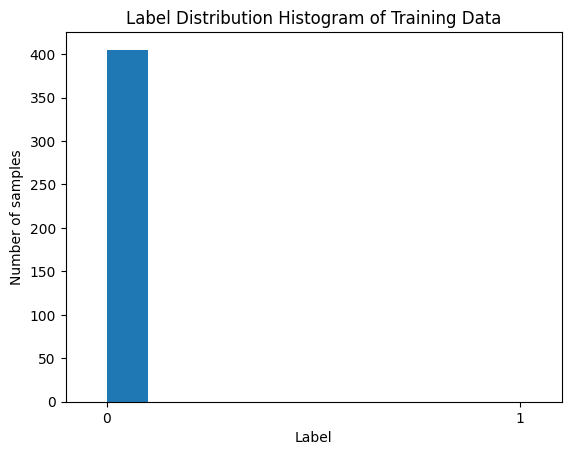

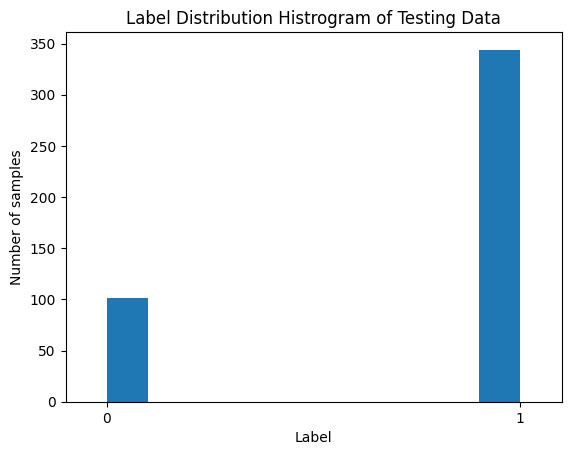

In [ ]:
import random

MODEL = "patchcore"
CONFIG_SELECT_PATH = f"/home/students/tyang/anomalib/src/anomalib/models/{MODEL}/config_select.yaml"
with open(file=CONFIG_SELECT_PATH, mode="r",encoding="utf-8") as f:
    print(f.read())
    
config_select = get_configurable_parameters(config_path=CONFIG_SELECT_PATH)

data_module_select = get_datamodule(config=config_select)
#data_module.prepare_data() # check if the dataset is avaliable
data_module_select.setup()

plt.title("Label Distribution Histogram of Training Data")
show_dataloader_label_distribution(data_module_select.train_dataloader())

plt.title("Label Distribution Histrogram of Testing Data")
show_dataloader_label_distribution(data_module_select.test_dataloader())

In [ ]:
from anomalib.utils.loggers import get_experiment_logger


model_select = get_model(config=config_select)    
experiment_logger = get_experiment_logger(config=config_select)
callbacks = get_callbacks(config=config_select)

trainer = Trainer(**config_select.trainer, callbacks=callbacks)
trainer.fit(model=model_select, train_dataloaders=data_module_select.train_dataloader(), val_dataloaders=data_module_select.val_dataloader())


/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


/home/students/tyang/anomalib/src/anomalib/utils/callbacks/__init__.py:153: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cach

Epoch 0:  11%|█         | 3/27 [00:05<00:41,  1.71s/it, loss=nan, v_num=33]

/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Epoch 0:  48%|████▊     | 13/27 [00:08<00:09,  1.49it/s, loss=nan, v_num=33]

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.94 GiB. GPU 0 has a total capacty of 10.91 GiB of which 1.23 GiB is free. Including non-PyTorch memory, this process has 9.09 GiB memory in use. Of the allocated memory 8.46 GiB is allocated by PyTorch, and 472.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model_select, datamodule=data_module_select)

Cannot perform pixel-level evaluation when task type is classification. Ignoring the following pixel-level metrics: ['F1Score', 'AUROC']
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 4/4 [00:27<00:00,  6.79s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC           0.825944185256958
      image_F1Score         0.47368425130844116
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
